<a href="https://colab.research.google.com/github/auroramugnai/ArXivClassification/blob/main/category_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ArXivClassification can classify scientific articles based on their categories
Here we perform a supervised classification where the labels are the articles' lists of categories and the features can be either their abstracts and titles or their lists of keywords, extracted from abstract and title.

⚡**N.B.**: If you just want to play with the classification and not with the pre-processing, you can find a zip file (`category_data.zip`) in this repository with some already processed data. If this is the case, you can run section 0) and then skip to section 4).

# 0) Initial setup

Clone the github repository and move to the inner directory.

In [3]:
!git clone https://github.com/auroramugnai/ArXivClassification.git
%cd ArXivClassification/ArXivClassification

Cloning into 'ArXivClassification'...
remote: Enumerating objects: 2090, done.
remote: Counting objects: 100% (381/381), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 2090 (delta 335), reused 275 (delta 271), pack-reused 1709
Receiving objects: 100% (2090/2090), 96.76 MiB | 12.97 MiB/s, done.
Resolving deltas: 100% (1150/1150), done.
/content/ArXivClassification/ArXivClassification


In [4]:
import random
import zipfile

import pandas as pd

import utils

In [5]:
SEED = 194 # fix random seed for reproducibility
random.seed(SEED)

# 1) Dataset building

In [ ]:
import json

import dask.bag as db

## 1.1 Download the dataset


The following line of code comes from clicking on "Copy API command" in https://www.kaggle.com/datasets/Cornell-University/arxiv.

In [ ]:
!kaggle datasets download -d Cornell-University/arxiv

Dataset URL: https://www.kaggle.com/datasets/Cornell-University/arxiv
License(s): CC0-1.0
arxiv.zip: Skipping, found more recently modified local copy (use --force to force download)


Unzip the downloaded file.

In [ ]:
with zipfile.ZipFile('./arxiv.zip', 'r') as zip_ref:
    zip_ref.extractall()

The unzipping creates an "arxiv-metadata-oai-snapshot.json". We now create a dask bag out of it.

In [ ]:
path = "./arxiv-metadata-oai-snapshot.json"
arxiv_data = db.read_text(path).map(json.loads)

# See how elements of the dataset look like.
arxiv_data.take(1)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

## 1.2 Get rid of some unnecessary infomation

In [ ]:
# Get the latest version of the articles.
get_latest_version = lambda x: x['versions'][-1]['created']

# Only keep articles published after 2022.
is_after_2022 = lambda x: int(get_latest_version(x).split(' ')[3]) > 2022

# Only keep some information.
cut_info = lambda x: {'id': x['id'],
                      'title': x['title'],
                      'category':x['categories'].split(' '),
                      'abstract':x['abstract'],}

arxiv_data_filtered = (arxiv_data.filter(is_after_2022).map(cut_info).compute())


# Create a pandas dataframe and save it to csv.
df = pd.DataFrame(arxiv_data_filtered)
df.head()

,id,title,category,abstract
0,0705.1329,Third Order Newton's Method for Zernike Polyno...,"[math.NA, cs.NA]",The Zernike radial polynomials are a system ...
1,0706.0190,Quantum Properties and Gravitational Field of ...,[physics.gen-ph],We find that a field with oscillations of ma...
2,0706.0725,Factorization of quadratic polynomials in the ...,"[math.AC, math.GM, math.NT, math.RA]",We establish necessary and sufficient condit...
3,0706.0859,"Profinite complexes of curves, their automorph...","[math.AG, math.NT]","Let ${\cal M}_{g,[n]}$, for $2g-2+n>0$, be t..."
4,0707.0434,Another generalization of Mason's ABC-theorem,[math.NT],We show a generalization of Mason's ABC-theo...


Look for the single-category occurrences in the dataset and plot the resulting histogram. Also, create a dictionary of the form {category: counts}.

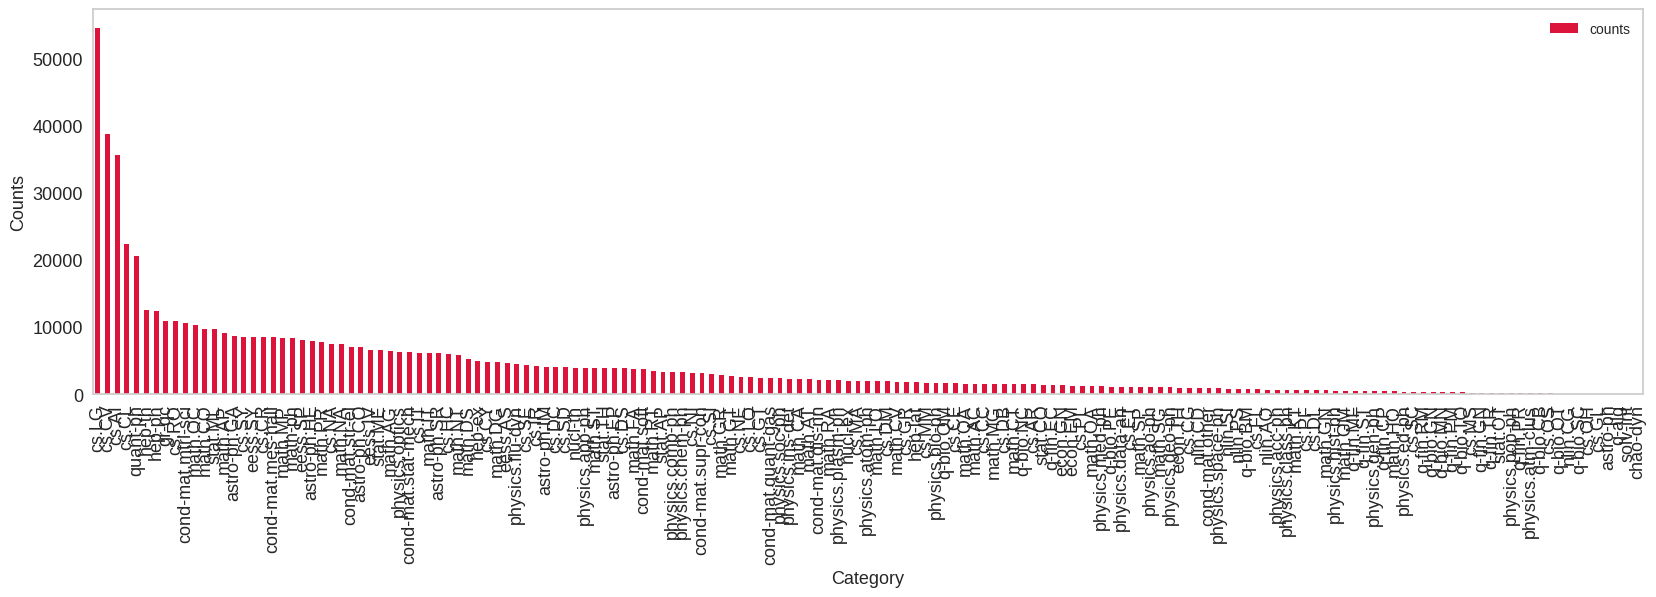

In [ ]:
utils.categories_as_lists(df) # take "category" as a column of lists
dictionary = utils.plot_df_counts(df.explode("category"), col="category")

## 1.3 Keep 20 categories

In [ ]:
# Get the list of all the single categories.
C  = list(dictionary.keys())
print(f'Number of categories appearing in the dataset: {len(C)}')

num_cat_to_keep = 20
sub_C = random.sample(C, num_cat_to_keep)  # a subset of C
print(f'Number of categories appearing in the dataset: {len(sub_C)}')

# Only keep articles whose categories are (all) in sub_C.
utils.categories_as_lists(df) # take "category" as a column of lists
check = lambda x: set(x).issubset(sub_C)
df = df.loc[df["category"].apply(check).loc[lambda x: x].index]
df = df.reset_index(drop=True)
df.head()

Number of categories appearing in the dataset: 159
Number of categories appearing in the dataset: 20


,id,title,category,abstract
0,1005.0555,Cosmic Microwave Background Mini-review,[astro-ph.CO],A compact overview of the status of CMB anis...
1,1005.1394,Bullet Cluster: Remarkable Revelations and End...,[astro-ph.CO],This study unveils new insights into the Bul...
2,1009.3204,Probing dark energy and neutrino mass from upc...,[astro-ph.CO],We discuss the synergy of the cosmic shear a...
3,1011.0862,Internal flows and energy circulation in light...,[physics.optics],We review optical phenomena associated with ...
4,1103.0255,A disintegration theorem,[math.FA],A new approach to disintegration of measures...


## 1.4 Remove categories with \#counts < `num_min`
First, find categories that have less than `num_min` counts, namely `cat_to_drop`.
Then, only keep those articles whose lists of categories have no intersection with `cat_to_drop`.


Number of articles in the dataset: 15495


,id,title,category,abstract
15490,2405.05929,Understanding Emotional Hijacking in Metaverse,[cs.HC],Emotions are an integral part of being human...
15491,2405.05931,Harms in Repurposing Real-World Sensory Cues f...,[cs.HC],The rise of Mixed Reality (MR) stimulates ne...
15492,2405.05933,Considering Avatar Crossing as Harm or Help fo...,[cs.HC],People leverage avatars to communicate nonve...
15493,2405.05940,Generalized Campanato Space Over Non-homogeneo...,[math.FA],The authors introduce generalized Campanato ...
15494,2405.05947,A Survey on Visualization Approaches in Politi...,[cs.HC],Politics is the set of activities related to...


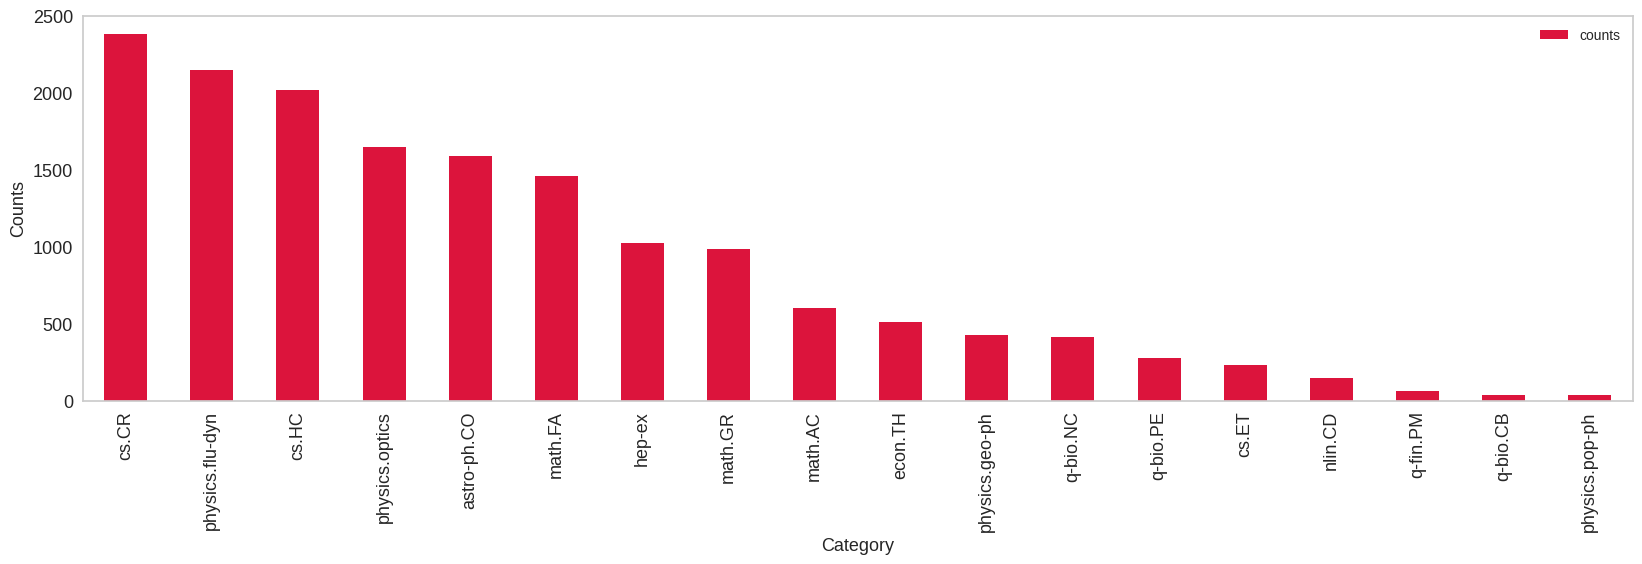

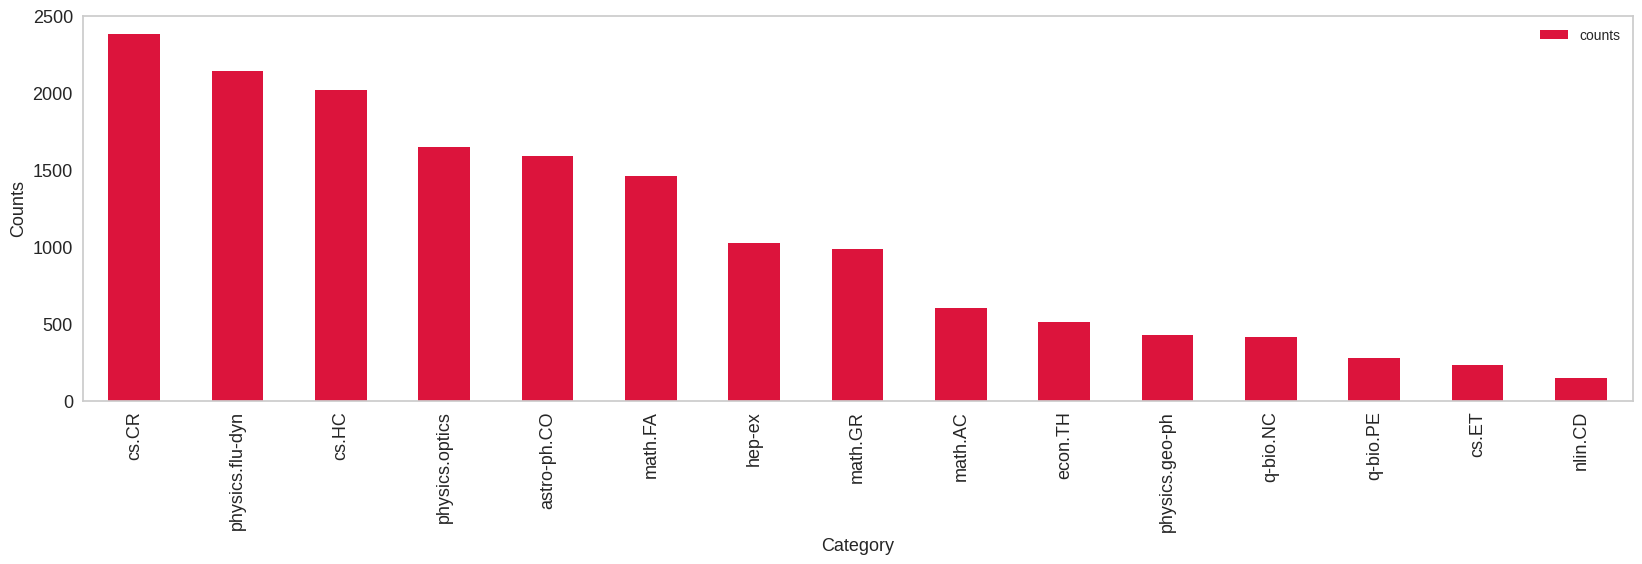

In [ ]:
num_min = 100

has_no_intersection = lambda cat_list: not (set(cat_list) & set(cat_to_drop))

while (min(dictionary.values()) < num_min):
    cat_to_drop = [cat for cat,count in dictionary.items() if count<num_min]
    utils.categories_as_lists(df) # take "category" as a column of lists
    df = df.loc[df["category"].apply(has_no_intersection).loc[lambda x: x].index]
    dictionary = utils.plot_df_counts(df.explode("category"), col="category")

df = df.reset_index(drop=True)
print(f'Number of articles in the dataset: {len(df)}')
df.tail()

# 2) Text-processing

In [ ]:
!pip install -U spacy -q
!python -m spacy download en_core_web_md -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 17.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import en_core_web_md
import spacy
from tqdm import tqdm

Clean out the strings (this step will take a while).

In [ ]:
# Remove stop words, punctuation, special characters, numbers...
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_md")
tqdm.pandas() # to display progress bar


# ... first on abstracts ...
abs_cleaner = lambda x: utils.text_cleaner(text=x["abstract"], nlp=nlp)
df["clean_abstract"] = df.progress_apply(abs_cleaner, axis=1)

# ... then on titles.
tit_cleaner = lambda x: utils.text_cleaner(text=x["title"], nlp=nlp)
df["clean_title"] = df.progress_apply(tit_cleaner, axis=1)

df.tail()

100%|██████████| 15635/15635 [05:02<00:00, 51.65it/s]


,id,title,category,abstract,clean_abstract,clean_title
15630,2405.05931,Harms in Repurposing Real-World Sensory Cues f...,['cs.HC'],The rise of Mixed Reality (MR) stimulates ne...,rise mixed reality mr stimulate new interactiv...,harm repurpose real world sensory cue mixed re...
15631,2405.05933,Considering Avatar Crossing as Harm or Help fo...,['cs.HC'],People leverage avatars to communicate nonve...,people leverage avatar communicate nonverbal b...,consider avatar crossing harm help adolescent ...
15632,2405.05940,Generalized Campanato Space Over Non-homogeneo...,['math.FA'],The authors introduce generalized Campanato ...,author introduce generalized campanato space r...,generalize campanato space non homogeneous spa...
15633,2405.05947,A Survey on Visualization Approaches in Politi...,['cs.HC'],Politics is the set of activities related to...,politics set activity relate strategic decisio...,survey visualization approach political scienc...
15634,physics/9704002,"Book Review: The Quantum Theory of Fields, Vol...",['physics.pop-ph'],"Review of the two volume set ""The Quantum Th...",review volume set quantum theory fields weinbe...,book review quantum theory fields vol ii weinberg


In [ ]:
# Join the strings.
df["clean_text"] = df["clean_title"] + " " + df["clean_abstract"]

# 3) Keyword extraction
⚡**N.B**: if you're going to use `clean_text` as the feature for the classification, you won't need keywords, so you can skip this section.

In [ ]:
!pip install --upgrade KeyBERT -q
!pip install --upgrade keyphrase-vectorizers -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.8/197.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.5/363.5 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.8/772.8 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.3/236.3 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 47.5 MB/s eta 0:00:00


In [ ]:
from keybert import KeyBERT
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
kw_model = KeyBERT('all-mpnet-base-v2')
top_n = 5

extraction = lambda x: utils.extract_kws(text=x["clean_text"],
                                        kw_model=kw_model,
                                        seed=x["clean_title"].split(" "),
                                        top_n=top_n)

df["keywords"] = df.progress_apply(extraction, axis=1)

# 4) Multilabel Classification


In [6]:
!pip install iterative-stratification
!pip install neattext
!pip install scikit-multilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 3.3 MB/s eta 0:00:00


In [7]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, classification_report, \
                            multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer, normalize
from sklearn.svm import SVC, LinearSVC
from yellowbrick.classifier import ClassificationReport

Uncomment these two cells to load the existing dataset in ```category_data.zip```.

In [8]:
# with zipfile.ZipFile("./category_data.zip", "r") as z:
#     z.extractall()

# df = pd.read_csv("category_data.csv", dtype=str)

Look for the single-category occurrences in the dataset and plot the resulting histogram. Also, create a dictionary of the form {category: counts}.

The least populated bin has 146 counts.
15495


,id,title,category,abstract,clean_abstract,clean_title,clean_text,keywords
15490,2503.0400,Understanding Emotional Hijacking in Metaverse,[cs.HC],Emotions are an integral part of being human...,emotion integral human experience range emotio...,understand emotional hijacking metaverse,understand emotional hijacking metaverse emoti...,"['emotion', 'vr', 'evoke', 'electroencephalogr..."
15491,2503.0400,Harms in Repurposing Real-World Sensory Cues f...,[cs.HC],The rise of Mixed Reality (MR) stimulates ne...,rise mixed reality mr stimulate new interactiv...,harm repurpose real world sensory cue mixed re...,harm repurpose real world sensory cue mixed re...,"['immersion', 'sensory', 'causal', 'repurpose'..."
15492,2503.0400,Considering Avatar Crossing as Harm or Help fo...,[cs.HC],People leverage avatars to communicate nonve...,people leverage avatar communicate nonverbal b...,consider avatar crossing harm help adolescent ...,consider avatar crossing harm help adolescent ...,"['avatar', 'virtual', 'adolescent', 'distancin..."
15493,2504.0400,Generalized Campanato Space Over Non-homogeneo...,[math.FA],The authors introduce generalized Campanato ...,author introduce generalized campanato space r...,generalize campanato space non homogeneous spa...,generalize campanato space non homogeneous spa...,"['commutator', 'space', 'homogeneous', 'bounde..."
15494,2504.0400,A Survey on Visualization Approaches in Politi...,[cs.HC],Politics is the set of activities related to...,politics set activity relate strategic decisio...,survey visualization approach political scienc...,survey visualization approach political scienc...,"['visualization', 'politics', 'research', 'fut..."


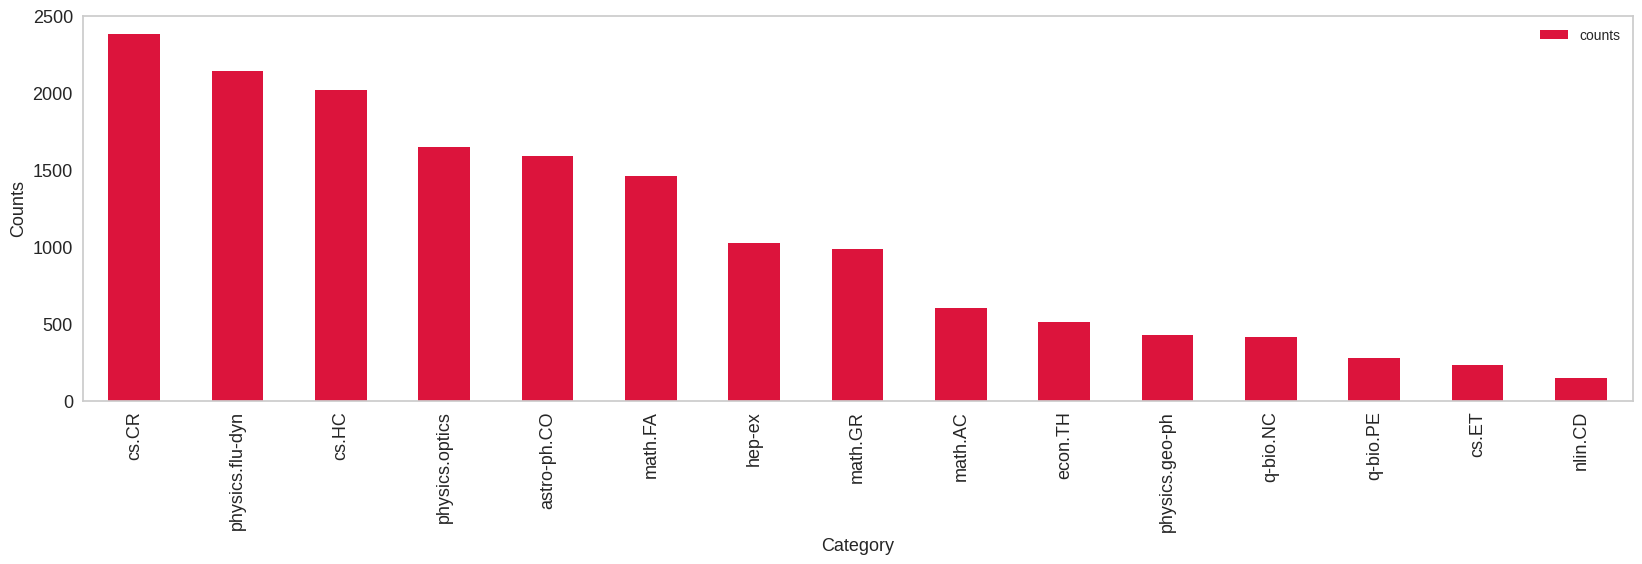

In [9]:
# utils.categories_as_lists(df) # take "category" as a column of lists
# dictionary = utils.plot_df_counts(df.explode("category"), col="category")

# print(f"The least populated bin has {min(dictionary.values())} counts.")
# print(len(df))
# df.tail()

## 4.1 Prepare features

Given an article:
- if `features == "keywords"`, its feature will be the list of its keywords
- if `features == "clean_text"`, its feature will be the clean text (abstract + title)


In [10]:
features = "clean_text"
# features = "keywords"

utils.categories_as_strings(df) # take "category" as a column of strings

if features == "clean_text":
    X = df["clean_text"]

elif features == "keywords":
    X = df["keywords"].map(lambda x: " ".join(eval(x)))

X = X.to_numpy()

## 4.2 Prepare labels

Given an article:
- its label y will be its lists of categories (in a one-hot-encoding)

In [11]:
utils.categories_as_lists(df) # take "category" as a column of lists
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["category"]) # y is now one-hot encoded
classes = mlb.classes_ # names of the columns of the one-hot-encoding

# Visualize y.
y_df = pd.DataFrame(y, columns=classes)
y_df

,astro-ph.CO,cs.CR,cs.ET,cs.HC,econ.TH,hep-ex,math.AC,math.FA,math.GR,nlin.CD,physics.flu-dyn,physics.geo-ph,physics.optics,q-bio.NC,q-bio.PE
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15490,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
15491,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
15492,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
15493,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


## 4.3 Do the classification with the best train/test split

In [12]:
msss = MultilabelStratifiedShuffleSplit(n_splits=10, test_size=0.4,
                                        random_state=SEED)

ovr = OneVsRestClassifier(LinearSVC(class_weight='balanced'),
                          n_jobs=-1)

model = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                  ('svm_model', ovr)])


# Find the train/test split that maximizes f1-score.
best_f = 0
for train_index, test_index in msss.split(X, y):
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]

   # Fit the train data.
   model.fit(X_train, y_train)

   # Make predictions on the test data.
   y_pred = model.predict(X_test)
   mat = multilabel_confusion_matrix(y_test, y_pred)

   f = f1_score(y_test, y_pred, average='weighted')
   print(f'f1_weighted = {round(f,3)}')

   if f>best_f:
       best_f = f
       best_X_train, best_X_test = X_train, X_test
       best_y_train, best_y_test = y_train, y_test
       best_y_pred, best_mat = y_pred, mat


print(f'best f1_weighted = {round(best_f,3)}\n')

f1_weighted = 0.937
f1_weighted = 0.937
f1_weighted = 0.936
f1_weighted = 0.937
f1_weighted = 0.937
f1_weighted = 0.939
f1_weighted = 0.937
f1_weighted = 0.941
f1_weighted = 0.943
f1_weighted = 0.941
best f1_weighted = 0.943



## 4.4 Show results

See the classification report.

In [13]:
f = best_f
X_train, X_test = best_X_train, best_X_test
y_train, y_test = best_y_train, best_y_test
y_pred, mat = best_y_pred, best_mat

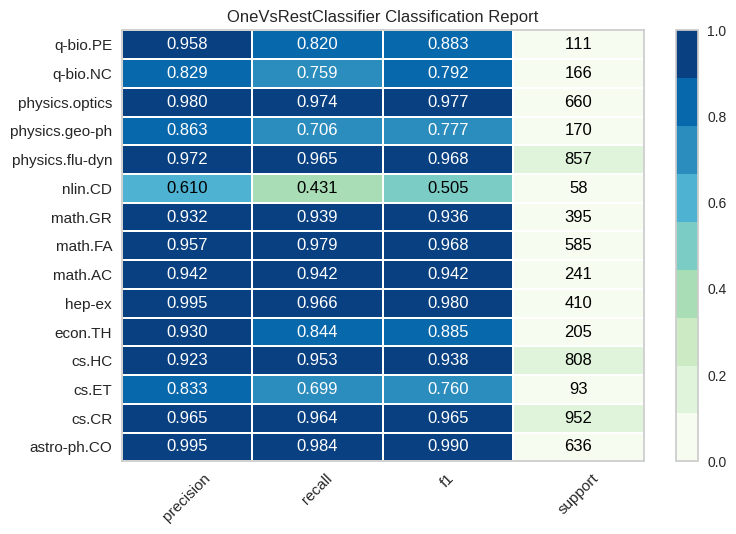

<Axes: title={'center': 'OneVsRestClassifier Classification Report'}>

In [14]:
visualizer = ClassificationReport(model, classes=classes, support=True,
                                  cmap='GnBu', fontsize=11)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test) # evaluate the model on the test data
visualizer.show()

Plot confusion matrices.

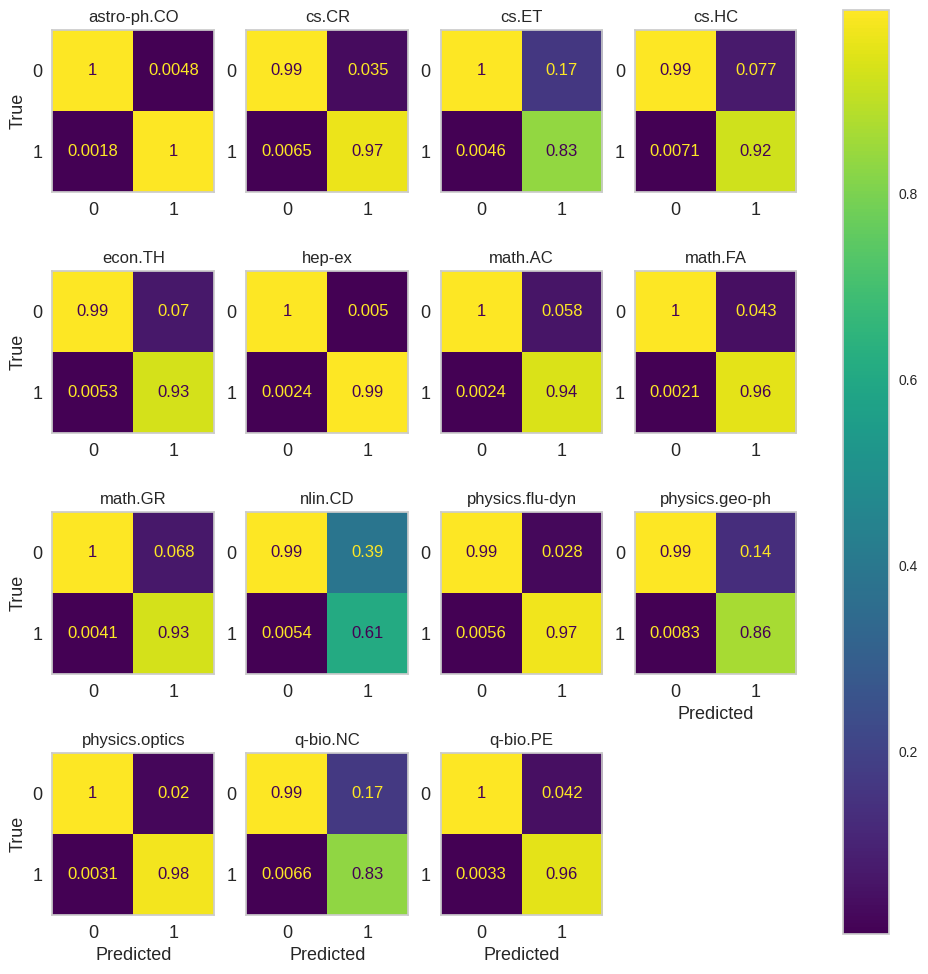

In [15]:
utils.plot_confusion_matrices(mat, classes)

(Optional) Show some predictions.

In [16]:
# Check the first 10 predictions.
y_test_list = mlb.inverse_transform(y_test)[:10]
y_pred_list = mlb.inverse_transform(y_pred)[:10]

for yt, yp in zip(y_test_list, y_pred_list):
  print("-"*20)
  print(f"  true   : {yt}")
  print(f"predicted: {yp}")

--------------------
  true   : ('math.GR',)
predicted: ('math.AC', 'math.GR')
--------------------
  true   : ('math.AC',)
predicted: ('math.AC',)
--------------------
  true   : ('math.FA',)
predicted: ('math.FA', 'math.GR')
--------------------
  true   : ('astro-ph.CO',)
predicted: ('astro-ph.CO',)
--------------------
  true   : ('physics.flu-dyn',)
predicted: ('physics.flu-dyn',)
--------------------
  true   : ('physics.flu-dyn',)
predicted: ()
--------------------
  true   : ('math.AC',)
predicted: ('math.AC',)
--------------------
  true   : ('cs.CR',)
predicted: ('cs.CR', 'math.GR')
--------------------
  true   : ('math.FA',)
predicted: ('math.FA',)
--------------------
  true   : ('math.AC',)
predicted: ()


Plot the ROC curve.

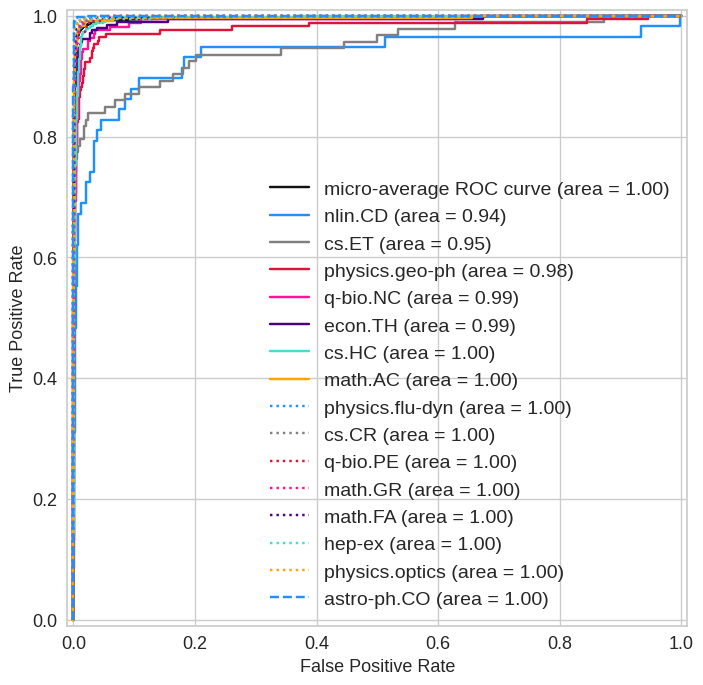

In [17]:
y_score = model.fit(X_train, y_train).decision_function(X_test)
utils.ROC(classes, y_test, y_score)

Plot the Precision-Recall curve.

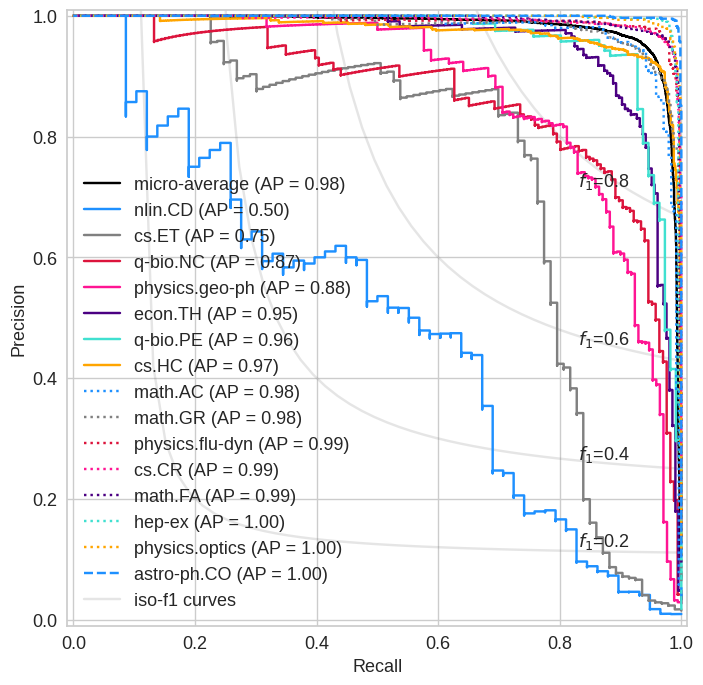

In [18]:
utils.PRC(classes, y_test, y_score)